In [1]:
from time import time

import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

from sklearn.decomposition import MiniBatchDictionaryLearning
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.feature_extraction.image import reconstruct_from_patches_2d
import scipy.misc

In [2]:
def wta(y, k):
    winners = np.argpartition(y, -k, axis=1)[:, -k:]
    idx = np.repeat(range(y.shape[0]), winners.shape[1]), winners.reshape(-1)
    yw = np.zeros(y.shape)
    yw[idx] = y[idx]
    return yw

def whiten(X, fudge=1E-18):
    Xcov = np.dot(X.T,X)
    d, V = np.linalg.eigh(Xcov)
    D = np.diag(1. / np.sqrt(d+fudge))
    W = np.dot(np.dot(V, D), V.T)
    X_white = np.dot(X, W)
    return X_white, W

def plot_weights(W):
    input_d = int(np.sqrt(W.shape[0]))
    hidden_d = int(np.sqrt(W.shape[1]))

    W_plot = np.zeros((input_d * hidden_d, input_d * hidden_d))
    i = 0
    for y in range(hidden_d):
        for x in range(hidden_d):
            W_plot[
                y*input_d:(y+1)*input_d,
                x*input_d:(x+1)*input_d
            ] = W[:, i].reshape(input_d, input_d)
            i += 1
    return shm(W_plot)

def shm(*matrices, **kwargs):
    plt.figure(1, figsize=(25,10))
    for m_id, matrix in enumerate(matrices):
        plt.subplot(len(matrices), 1, m_id+1)
        plt.imshow(np.squeeze(matrix).T, cmap='gray', origin='lower')
        plt.colorbar()

    if kwargs.get("file"):
        plt.savefig(kwargs["file"])
        plt.clf()
    else:
        plt.show()
    
def to_binary(x):
    return np.where(x > 0, 1.0, 0.0).astype(np.uint8)
        
def relu(x):
    return np.where(x > 0, x, 0.0)

def norm(w, factor=1.0):
    for i in range(w.shape[1]):
        w[:, i] = factor * w[:, i] / np.sqrt(np.sum(np.square(w[:,i])))

def weights_inner_product(W, p):
    return np.asarray([np.linalg.norm(W[:, ni], ord=p) for ni in range(W.shape[1])])

def shl(*vector, **kwargs):
    plt.figure(1, figsize=(15,10))
    labels = kwargs.get("labels", [])
    for id, v in enumerate(vector):
        if len(labels) > 0:
            plt.plot(np.squeeze(v), label=labels[id])
        else:
            plt.plot(np.squeeze(v))

    if len(labels) > 0:
        plt.legend()

    if kwargs.get("file"):
        plt.savefig(kwargs["file"])
        plt.clf()
    else:
        plt.show()

In [3]:
face = scipy.misc.face(gray=True)

# Convert from uint8 representation with values between 0 and 255 to
# a floating point representation with values between 0 and 1.
face = face / 255.

# downsample for higher speed
face = face[::4, ::4] + face[1::4, ::4] + face[::4, 1::4] + face[1::4, 1::4]
face /= 4.0
height, width = face.shape

# Extract all reference patches from the left half of the image
print('Extracting reference patches...')
t0 = time()
patch_size = (7, 7)
data = extract_patches_2d(face[:, :width // 2], patch_size)
data = data.reshape(data.shape[0], -1)
data -= np.mean(data, axis=0)
data /= np.std(data, axis=0)
data, W_whiten = whiten(data)
print('done in %.2fs.' % (time() - t0))

Extracting reference patches...
done in 0.04s.


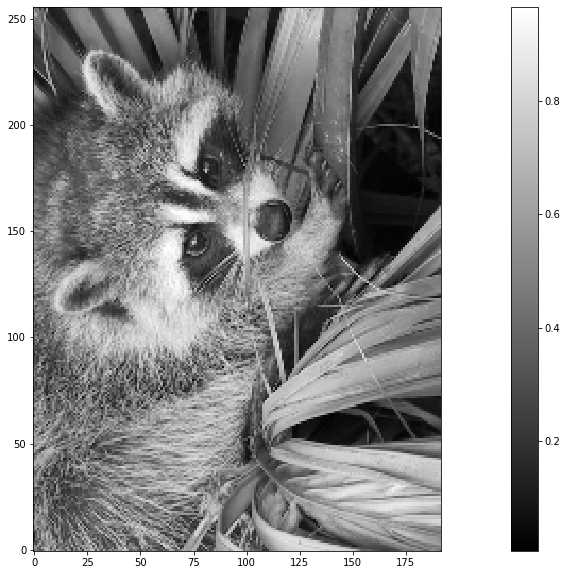

In [4]:
shm(face)

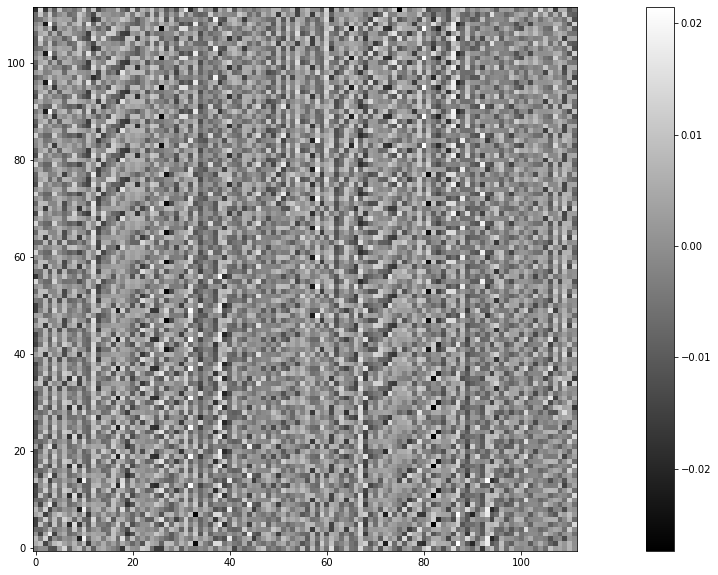

In [5]:
plot_weights(data[:256].T)

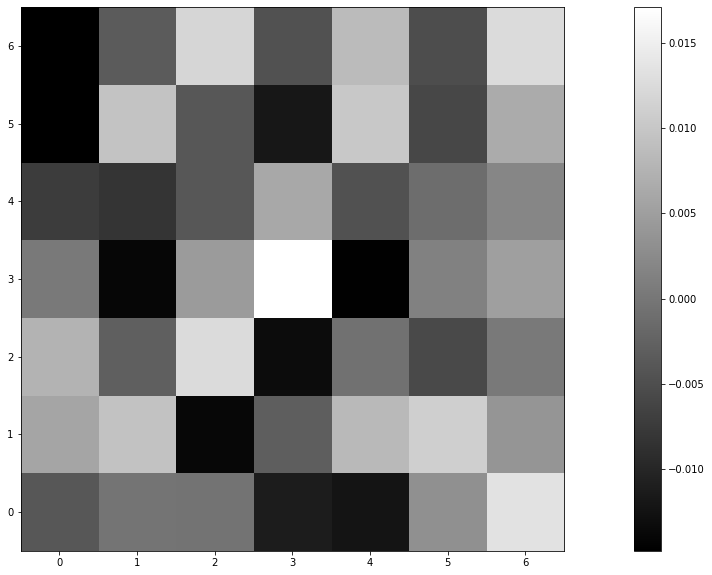

In [6]:
shm(data[0].reshape(patch_size))

In [132]:
X = data

np.random.seed(0)
theta = 0.0
a = 10.0
# a = 0.001
b = 1.0
epochs = 500
learning_rate = 0.01
batch_size = 200
num_hidden = 49
number_of_batches = X.shape[0] // batch_size
dt = 0.1

beta_norm = 0.01

alpha_res = 5.0
alpha_norm = 0.005
W_max = 1.0
W_min = 0.0

tau_avg = 100.0

W = np.random.normal(0.0, 1.0, (X.shape[1], num_hidden))
# norm(W)
W_sign = np.sign(W)

R = np.zeros((num_hidden, num_hidden))
# R = 0.01 * np.abs(np.random.normal(0.0, 1.0, (num_hidden, num_hidden)))
np.fill_diagonal(R, 0)

W0 = W.copy()
R0 = R.copy()

In [133]:
y_stat = np.zeros((epochs, num_hidden))
converge_stat = np.zeros((epochs, 2))

y_avg = np.zeros((num_hidden,))
y_avg_stat = np.zeros((epochs, num_hidden))

for epoch in range(epochs):
    dW_norm = 0.0
    dR_norm = 0.0
    t0 = time()
    for i in range(number_of_batches):
        x = X[i*batch_size:(i+1)*batch_size,:]
        
#         y = np.zeros((batch_size, num_hidden))
#         u = np.zeros((batch_size, num_hidden))
#         for _ in range(5):
#             du = np.dot(x, W) - np.dot(y, R)
#             u += dt * du
#             y = a * relu(u - theta)
            
        y = a * relu(np.dot(x, W))
        
#         y = wta(y, 5)
        
        # statistics

        y_avg_cur = np.mean(y, 0)
        
        y_avg = (1.0 - 1.0 / tau_avg) * y_avg + (1.0 / tau_avg) * y_avg_cur
        y_avg_stat[epoch] += y_avg
        
        # learning
        
        if epoch < 10:
            continue

#         y_deriv = y * (y - y_avg)
        y_deriv = y

        # hard constraints logic
        
    
#         dR = np.dot(y.T, y)        
        dW = np.dot(x.T, y_deriv) - beta_norm * np.sum(y_deriv * y, 0, keepdims=True) * W
#         W_res = np.sum(np.abs(W), 0, keepdims=True)
#         dW = np.dot(x.T, y_deriv) - W_sign * alpha_norm * (W_res - alpha_res)

        
        dW_norm += np.linalg.norm(dW)
#         dR_norm += np.linalg.norm(dR)
#         dW_norm += np.mean(W_res)
    
        W += learning_rate * dW
#         R += learning_rate * dR
#         np.fill_diagonal(R, 0)

#         W_abs = np.abs(W)
#         W = W_sign * np.where(W_abs > W_max, W_max, np.where(W_abs < W_min, W_min, W_abs))
        
    t1 = time()
#     norm(W)
    
    y_avg_stat[epoch] /= number_of_batches

    converge_stat[epoch, 0] = dW_norm / number_of_batches
    converge_stat[epoch, 1] = dR_norm / number_of_batches

    if epoch % (epochs // 10) == 0 or epoch == epochs - 1:
        print(
            "Epoch {}, "
            "|dW| = {:.3f}, "
            "min(W) = {:.3f}, "
            "max(W) = {:.3f}, "
            "|W| = {:.3f}, "
            "|dR| = {:.3f}, "
            "<y> = {:.3f}, took {:.3f}s".format(
            epoch, 
            converge_stat[epoch, 0],
            np.min(W),
            np.max(W),
            weights_inner_product(W, 2)[0],
            converge_stat[epoch, 1],
            np.mean(y_stat[epoch]),
            t1-t0
            #np.mean(weights_inner_product(W, 2))
        ))    

Epoch 0, |dW| = 0.000, min(W) = -3.117, max(W) = 3.171, |W| = 6.763, |dR| = 0.000, <y> = 0.000, took 0.031s
Epoch 50, |dW| = 1.090, min(W) = -1.614, max(W) = 1.195, |W| = 3.181, |dR| = 0.000, <y> = 0.000, took 0.034s
Epoch 100, |dW| = 1.156, min(W) = -1.750, max(W) = 1.005, |W| = 3.163, |dR| = 0.000, <y> = 0.000, took 0.030s
Epoch 150, |dW| = 1.205, min(W) = -1.818, max(W) = 0.912, |W| = 3.163, |dR| = 0.000, <y> = 0.000, took 0.030s
Epoch 200, |dW| = 1.231, min(W) = -1.824, max(W) = 0.860, |W| = 3.163, |dR| = 0.000, <y> = 0.000, took 0.030s
Epoch 250, |dW| = 1.242, min(W) = -1.787, max(W) = 0.838, |W| = 3.163, |dR| = 0.000, <y> = 0.000, took 0.029s
Epoch 300, |dW| = 1.244, min(W) = -1.704, max(W) = 0.872, |W| = 3.163, |dR| = 0.000, <y> = 0.000, took 0.030s
Epoch 350, |dW| = 1.242, min(W) = -1.582, max(W) = 0.891, |W| = 3.163, |dR| = 0.000, <y> = 0.000, took 0.039s
Epoch 400, |dW| = 1.237, min(W) = -1.460, max(W) = 0.897, |W| = 3.163, |dR| = 0.000, <y> = 0.000, took 0.043s
Epoch 450, |d

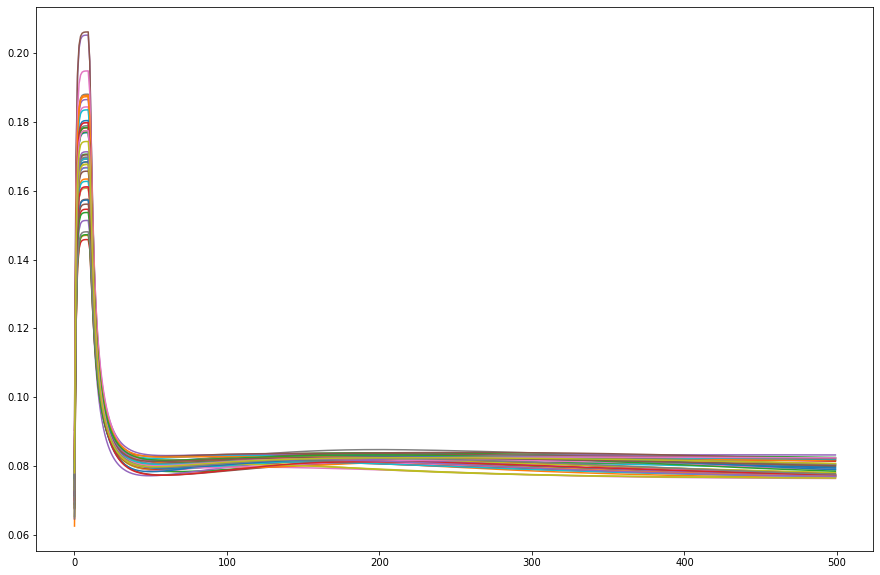

In [139]:
shl(y_avg_stat)

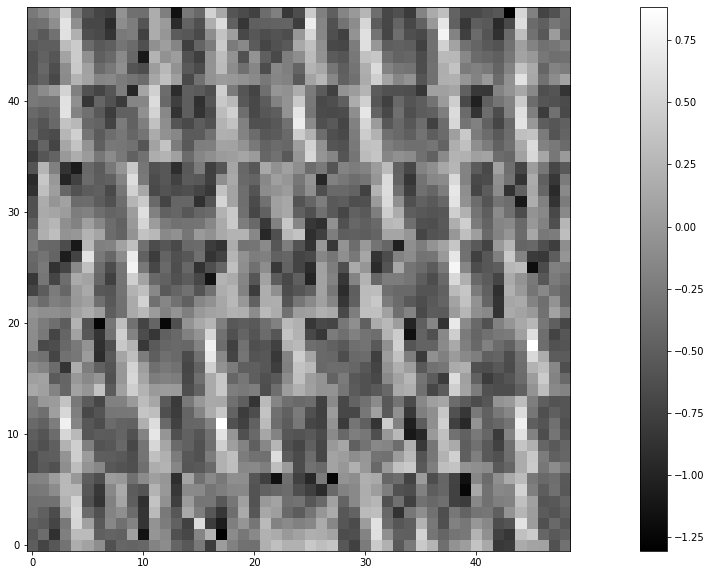

In [140]:
plot_weights(W)

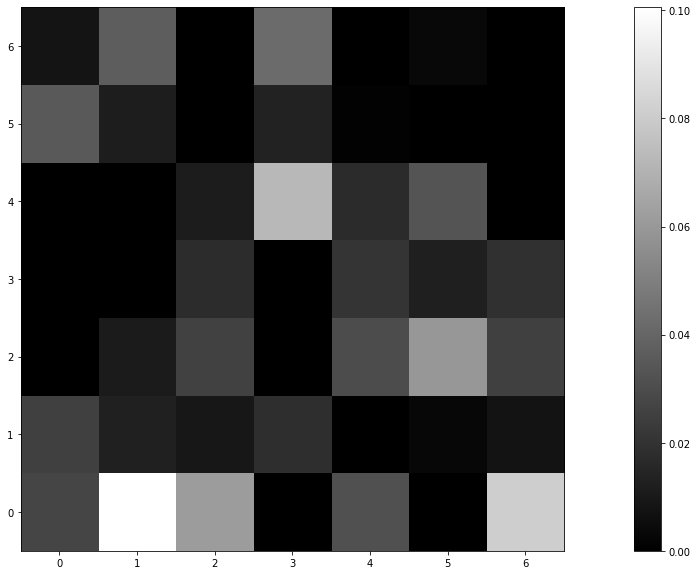

In [141]:
shm(y[0].reshape((7,7)))

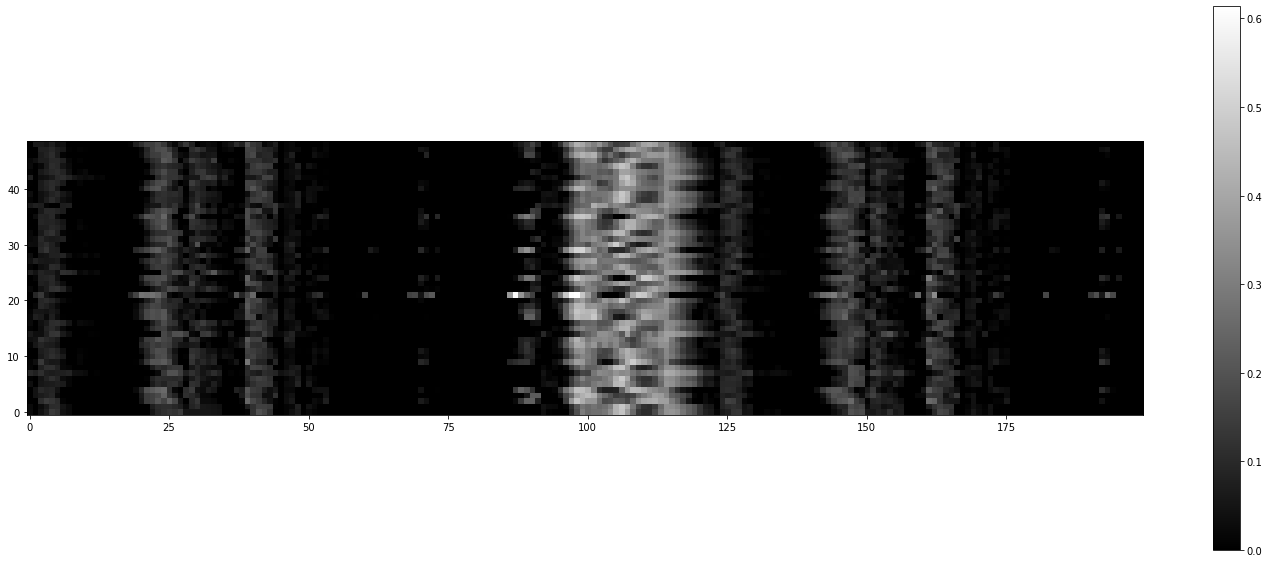

In [142]:
shm(y)

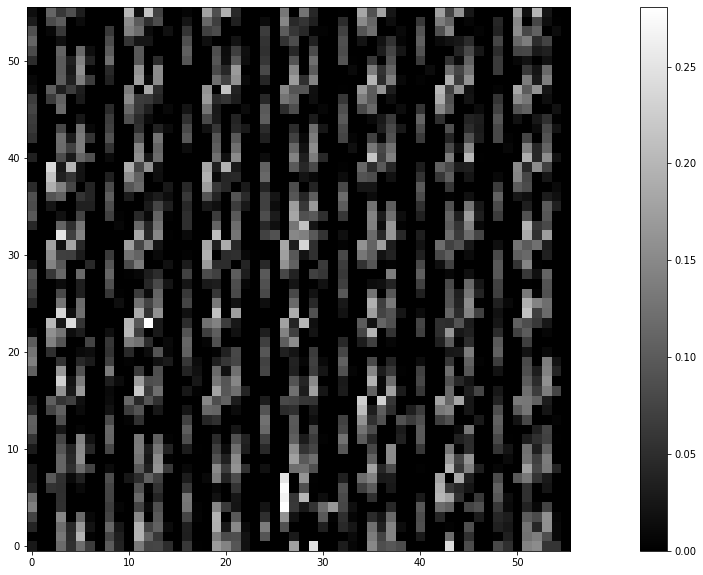

In [143]:
plot_weights(y[:64])